In [9]:
%pip install -r requirements.txt


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
from pathlib import Path
import pandas as pd

DATA_DIR = Path("data")
csv_files = sorted(DATA_DIR.glob("m1_*.csv"))

if not csv_files:
    raise FileNotFoundError(f"No m1_*.csv files found in {DATA_DIR.resolve()}")

df = pd.concat((pd.read_csv(path) for path in csv_files), ignore_index=True)

df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True, errors="coerce")

# m1 load_factor format: size=256K/lf=0.10
parts = df["load_factor"].astype(str).str.extract(r"size=(?P<index_size>[^/]+)/lf=(?P<occupancy>[0-9.]+)")
df["index_size"] = parts["index_size"]
df["occupancy"] = pd.to_numeric(parts["occupancy"], errors="coerce")

df.head()

,timestamp,impl,op,load_factor,metric,value,unit,tag,index_size,occupancy
0,2026-02-27 05:32:17.273804+00:00,radix_tree,iter,size=128M/lf=0.10,mean,8.088274e+07,ns,NaN,128M,0.1
1,2026-02-27 05:32:17.273804+00:00,radix_tree,iter,size=128M/lf=0.10,median,8.088274e+07,ns,NaN,128M,0.1
2,2026-02-27 05:32:17.273804+00:00,radix_tree,iter,size=128M/lf=0.10,std_dev,2.273422e+06,ns,NaN,128M,0.1
3,2026-02-27 05:32:17.273804+00:00,radix_tree,iter,size=128M/lf=0.10,throughput_ops_per_sec,1.659411e+08,ops/s,NaN,128M,0.1
4,2026-02-27 05:32:17.273804+00:00,radix_tree,iter,size=128M/lf=0.90,mean,1.053782e+08,ns,NaN,128M,0.9


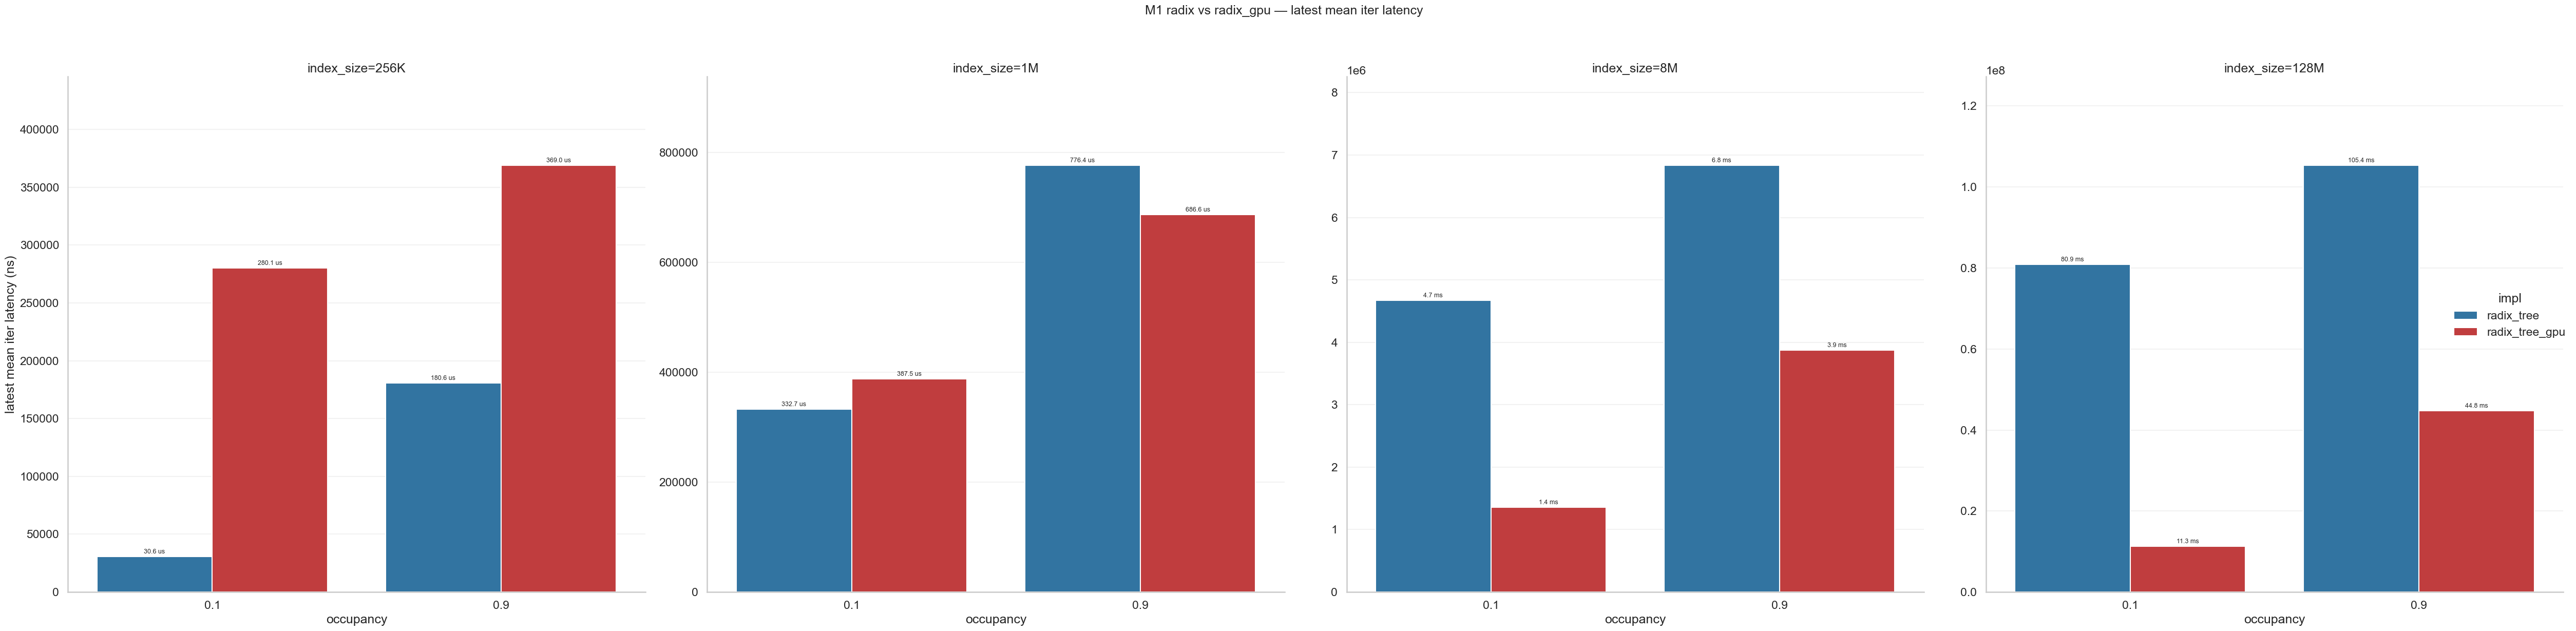

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="talk")

# Compare latest mean iter latency for radix vs radix_gpu.
plot_df = df[(df["op"] == "iter") & (df["metric"] == "mean") & (df["unit"] == "ns")].copy()
plot_df = plot_df[plot_df["impl"].isin(["radix_tree", "radix_tree_gpu"])].copy()

# Focus on the occupancy levels requested for first pass.
target_occupancies = [0.10, 0.90]
plot_df = plot_df[plot_df["occupancy"].isin(target_occupancies)].copy()

if plot_df.empty:
    raise ValueError("No m1 iter mean/ns rows found for radix_tree vs radix_tree_gpu at occupancies 0.10/0.90")

# Keep only latest value per (impl, index_size, occupancy)
latest = (
    plot_df.sort_values(["timestamp", "impl", "index_size", "occupancy"]) 
    .drop_duplicates(["impl", "index_size", "occupancy"], keep="last")
)

# Stable ordering for index sizes and impl colors/labels.
size_order_hint = ["256K", "1M", "8M", "128M"]
index_sizes = [s for s in size_order_hint if s in latest["index_size"].unique()]
index_sizes += [s for s in sorted(latest["index_size"].unique()) if s not in index_sizes]

latest["index_size"] = pd.Categorical(latest["index_size"], categories=index_sizes, ordered=True)
latest["impl"] = pd.Categorical(latest["impl"], categories=["radix_tree", "radix_tree_gpu"], ordered=True)

palette = {"radix_tree": "#1f77b4", "radix_tree_gpu": "#d62728"}

# One chart per index size, occupancies shown together on x-axis.
g = sns.catplot(
    data=latest.sort_values(["index_size", "occupancy", "impl"]),
    kind="bar",
    x="occupancy",
    y="value",
    hue="impl",
    col="index_size",
    sharey=False,
    height=12,
    aspect=1,
    palette=palette,
    errorbar=None,
)

g.set_titles(col_template="index_size={col_name}")
g.set_axis_labels("occupancy", "latest mean iter latency (ns)")

# Add readable labels above bars.
def human_latency(ns):
    if pd.isna(ns):
        return "-"
    ns = float(ns)
    if ns < 1_000:
        return f"{ns:.1f} ns"
    if ns < 1_000_000:
        return f"{ns/1_000:.1f} us"
    if ns < 1_000_000_000:
        return f"{ns/1_000_000:.1f} ms"
    return f"{ns/1_000_000_000:.2f} s"

for ax in g.axes.flat:
    for container in ax.containers:
        labels = [human_latency(v) if not pd.isna(v) else "" for v in container.datavalues]
        ax.bar_label(container, labels=labels, padding=2, fontsize=9)

    y0, y1 = ax.get_ylim()
    ax.set_ylim(0, y1 * 1.15)
    ax.grid(True, axis="y", alpha=0.25)

plt.suptitle("M1 radix vs radix_gpu — latest mean iter latency", y=1.03, fontsize=18)
plt.tight_layout()
plt.show()

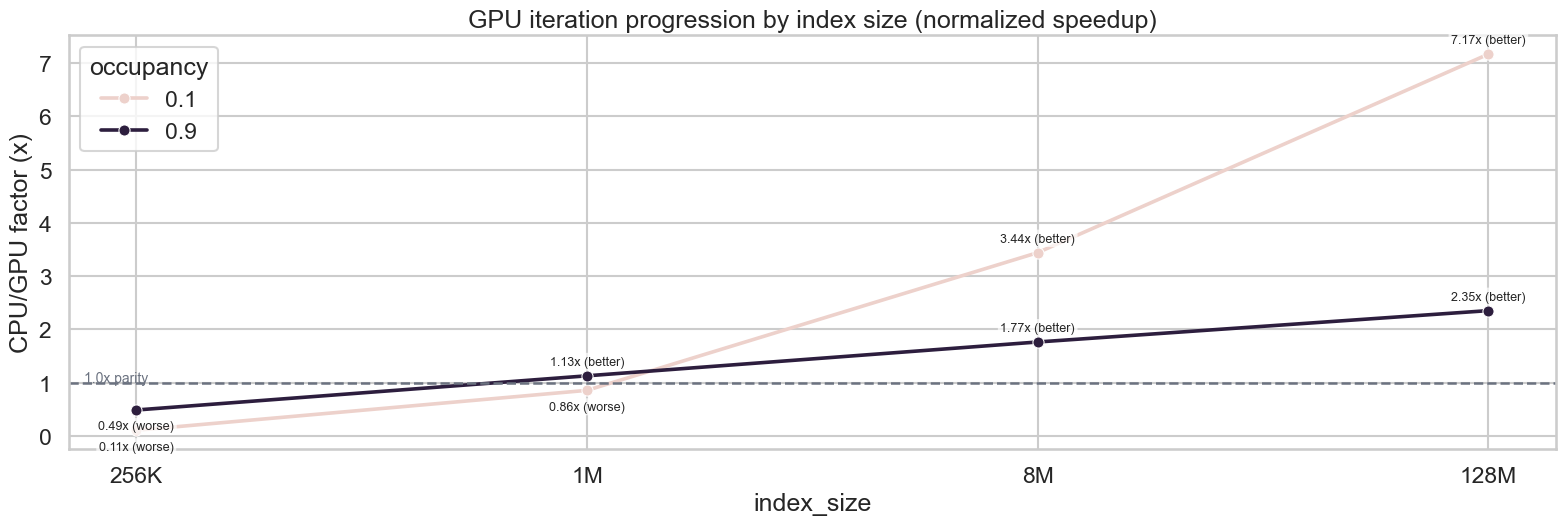

impl,index_size,occupancy,cpu_ns,gpu_ns,speedup_factor
4,256K,0.1,3.055750e+04,2.800663e+05,0.109108
2,1M,0.1,3.326698e+05,3.875311e+05,0.858434
6,8M,0.1,4.671577e+06,1.357114e+06,3.442288
0,128M,0.1,8.088274e+07,1.128654e+07,7.166303
5,256K,0.9,1.806078e+05,3.689852e+05,0.489472
3,1M,0.9,7.764276e+05,6.865560e+05,1.130902
7,8M,0.9,6.836690e+06,3.872154e+06,1.765604
1,128M,0.9,1.053782e+08,4.476274e+07,2.354150


In [12]:
# GPU progression chart (normalized): CPU time / GPU time
# >1.0 means GPU is better (faster), <1.0 means GPU is worse.

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="talk")

speed_df = df[(df["op"] == "iter") & (df["metric"] == "mean") & (df["unit"] == "ns")].copy()
speed_df = speed_df[speed_df["impl"].isin(["radix_tree", "radix_tree_gpu"])].copy()

# Keep latest row per impl/index_size/occupancy
latest_speed = (
    speed_df.sort_values(["timestamp", "impl", "index_size", "occupancy"])
    .drop_duplicates(["impl", "index_size", "occupancy"], keep="last")
)

pivot = (
    latest_speed.pivot_table(
        index=["index_size", "occupancy"],
        columns="impl",
        values="value",
        aggfunc="first",
    )
    .reset_index()
)

if not {"radix_tree", "radix_tree_gpu"}.issubset(set(pivot.columns)):
    raise ValueError("Need both radix_tree and radix_tree_gpu latest values to compute speedup")

pivot["speedup_factor"] = pivot["radix_tree"] / pivot["radix_tree_gpu"]

size_order = ["256K", "1M", "8M", "128M"]
present_sizes = [s for s in size_order if s in pivot["index_size"].unique()]
pivot["index_size"] = pd.Categorical(pivot["index_size"], categories=present_sizes, ordered=True)
pivot = pivot.sort_values(["occupancy", "index_size"])

# Optional first-pass focus on occupancies used earlier
target_occupancies = [0.10, 0.90]
pivot = pivot[pivot["occupancy"].isin(target_occupancies)]

plt.figure(figsize=(16, 5.6))
ax = sns.lineplot(
    data=pivot,
    x="index_size",
    y="speedup_factor",
    hue="occupancy",
    marker="o",
    linewidth=2.6,
    markersize=8,
)

ax.axhline(1.0, linestyle="--", linewidth=1.8, color="#6b7280")
ax.text(0.01, 1.01, "1.0x parity", transform=ax.get_yaxis_transform(), color="#6b7280", fontsize=10)

for _, row in pivot.iterrows():
    f = float(row["speedup_factor"])
    label = f"{f:.2f}x ({'better' if f >= 1.0 else 'worse'})"
    yoff = 8 if f >= 1.0 else -14
    ax.annotate(
        label,
        xy=(row["index_size"], f),
        xytext=(0, yoff),
        textcoords="offset points",
        ha="center",
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7),
    )

ax.set_title("GPU iteration progression by index size (normalized speedup)")
ax.set_xlabel("index_size")
ax.set_ylabel("CPU/GPU factor (x)")
ax.legend(title="occupancy", loc="best", frameon=True)

plt.tight_layout()
plt.show()

display(
    pivot[["index_size", "occupancy", "radix_tree", "radix_tree_gpu", "speedup_factor"]]
    .rename(columns={
        "radix_tree": "cpu_ns",
        "radix_tree_gpu": "gpu_ns",
    })
)